In [ ]:
# !pip install causalml catboost scikit-uplift 

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight 
from sklearn.linear_model import LogisticRegression, LinearRegression 

from causalml.inference.meta import BaseSClassifier, BaseTClassifier, BaseXClassifier, BaseRClassifier
from causalml.inference.tree import UpliftRandomForestClassifier
from catboost import CatBoostClassifier

from sklift.metrics.metrics import qini_auc_score
from sklift.viz import plot_qini_curve

ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/data/criteo-uplift-v2.1.csv", sep=",")
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float64
 1   f1          float64
 2   f2          float64
 3   f3          float64
 4   f4          float64
 5   f5          float64
 6   f6          float64
 7   f7          float64
 8   f8          float64
 9   f9          float64
 10  f10         float64
 11  f11         float64
 12  treatment   int64  
 13  conversion  int64  
 14  visit       int64  
 15  exposure    int64  
dtypes: float64(12), int64(4)
memory usage: 1.7 GB


Описание данных: https://ailab.criteo.com/criteo-uplift-prediction-dataset/      
      
Data description:
This dataset is constructed by assembling data resulting from several incrementality tests, a particular randomized trial procedure where a random part of the population is prevented from being targeted by advertising. it consists of 25M rows, each one representing a user with 11 features, a treatment indicator and 2 labels (visits and conversions).      

У нас правда не 25 млн строк, но ключевой момент не в этом. А в том, что теперь мы понимаем, что есть treatment и индикаторами  выступают conversion и visit.





In [ ]:
df[['treatment','conversion', 'visit']].value_counts().reset_index(name='count')

,treatment,conversion,visit,count
0,1,0,0,11305831
1,0,0,0,2016832
2,1,0,1,540113
3,0,0,1,76042
4,1,1,1,36711
5,0,1,1,4063


Создадим 'target_class' по сочетаниям воздействия и отдачи

In [ ]:
def declare_tartet_class(df):
    
    #не было воздействия и не было отдачи
    df['target_class'] = 0 

    #не было воздействия но была отдача
    df.loc[(df['treatment'] == 0) & (df['conversion'] == 0) & (df['visit'] != 0),'target_class'] = 1 
    df.loc[(df['treatment'] == 0) & (df['conversion'] != 0) & (df['visit'] != 0),'target_class'] = 1

    #было воздействие но не было отдачи
    df.loc[(df['treatment'] != 0) & (df['conversion'] == 0) & (df['visit'] == 0),'target_class'] = 2
             
    #было воздействие и была отдача
    df.loc[(df['treatment'] != 0) & (df['conversion'] == 0) & (df['visit'] != 0),'target_class'] = 3 
    df.loc[(df['treatment'] != 0) & (df['conversion'] != 0) & (df['visit'] != 0),'target_class'] = 3

    return df 

In [ ]:
df = declare_tartet_class(df)
df['target_class'].value_counts()

2    11305831
0     2016832
3      576824
1       80105
Name: target_class, dtype: int64

In [ ]:
feature_cols = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8',
              'f9', 'f10', 'f11']
target_col = 'conversion'
treatment_col = 'treatment'

В виду нехватки памяти, UpliftRandomForest строится только 10% от представленного датасета. Для честности эксперимента, прогоним все модели на этом объёме. 

In [ ]:
df_large, df_small = train_test_split(df, stratify=df[[treatment_col, target_col]], random_state=13, test_size=0.1)
df_train, df_test = train_test_split(df_small, stratify=df_small[[treatment_col, target_col]], random_state=13, test_size=0.3)
df_train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure,target_class
1966027,23.096384,10.059654,8.214383,4.679882,10.280525,4.115453,-7.570316,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,2
6676931,12.616365,10.059654,8.926048,4.679882,10.280525,4.115453,0.294443,4.833815,3.835145,13.190056,5.300375,-0.168679,0,0,0,0,0
2363177,12.616365,10.059654,8.888273,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0,2
402933,26.709396,10.059654,8.214383,4.679882,10.280525,4.115453,-8.493011,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,2
11157998,12.616365,10.059654,8.857104,4.679882,10.280525,4.115453,0.294443,4.833815,3.943716,13.190056,5.300375,-0.168679,1,0,0,0,2


In [ ]:
def qini_df(df, uplift_score):
    # Отранжируем выборку по значению uplift в убывающем порядке
    ranked = df.sort_values(uplift_score, ascending=False)
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # Посчитаем в отсортированном датафрейме основные показатели, которые используются при расчете qini
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # Qini curve
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # Random curve
    ranked['random_uplift'] = round(ranked[uplift_score].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked[uplift_score].rank(pct=True, ascending=False)
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    
    return (ranked['uplift'] - ranked['random_uplift']).sum()

In [ ]:
# class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(df_train.conversion), y=df_train.conversion)
# train_class_weights = dict(enumerate(class_weights))

Балансировка по классам не дала существенного прироста в итоговых значениях, но дала значительный прирост по времени работы моделей. Решено было не использовать.

In [ ]:
# S-learner
s_learner = BaseSClassifier(learner=CatBoostClassifier(random_seed=13, verbose=0))
# class_weights=train_class_weights

s_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = s_learner.predict(np.array(df_test[feature_cols].values.copy()))


df_test['uplift_score_s'] = uplift_vals

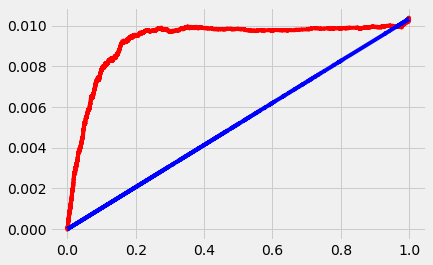

1701.9433199999999

In [ ]:
score_s = qini_df(df_test, 'uplift_score_s')
score_s

1701.9433199999999

In [ ]:
qini_s = qini_auc_score(df_test[target_col], df_test['uplift_score_s'], df_test[treatment_col], negative_effect=True)
qini_s

0.16757280119831666

0.16757280119831666

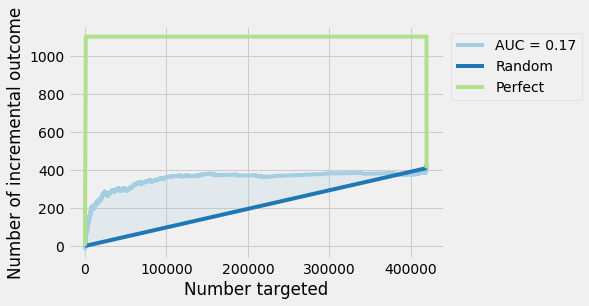

In [ ]:
plot_qini_curve(df_test[target_col], df_test['uplift_score_s'], df_test[treatment_col], perfect=True)

In [ ]:
# T-learner
t_learner = BaseTClassifier(learner=CatBoostClassifier(random_seed=13, verbose=0))

t_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = t_learner.predict(np.array(df_test[feature_cols].values.copy()))

df_test['uplift_score_t'] = uplift_vals

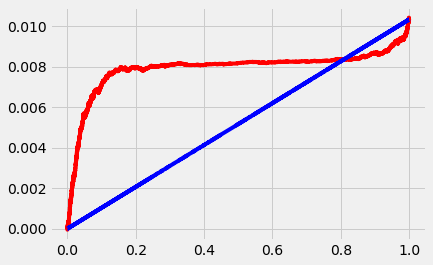

1149.3000699999998

In [ ]:
score_t = qini_df(df_test, 'uplift_score_t')
score_t

1149.3000699999998

In [ ]:
qini_t = qini_auc_score(df_test[target_col], df_test['uplift_score_t'], df_test[treatment_col], negative_effect=True)
qini_t

0.18040629625802793

0.18040629625802793

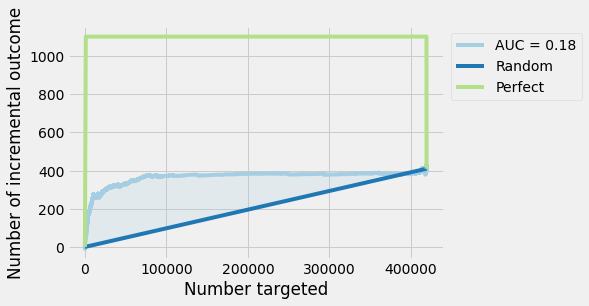

In [ ]:
plot_qini_curve(df_test[target_col], df_test['uplift_score_t'], df_test[treatment_col], perfect=True)

In [ ]:
# X-learner
x_learner = BaseXClassifier(outcome_learner=LogisticRegression(random_state=13),
                           effect_learner=LinearRegression())

x_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = x_learner.predict(np.array(df_test[feature_cols].values.copy()))

df_test['uplift_score_x'] = uplift_vals

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

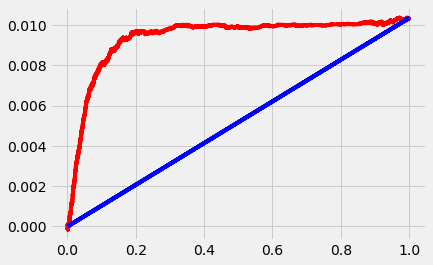

1752.8238499999989

In [ ]:
score_x = qini_df(df_test, 'uplift_score_x')
score_x

1752.8238499999989

In [ ]:
qini_x = qini_auc_score(df_test[target_col], df_test['uplift_score_x'], df_test[treatment_col], negative_effect=True)
qini_x

0.20747580080128103

0.20747580080128103

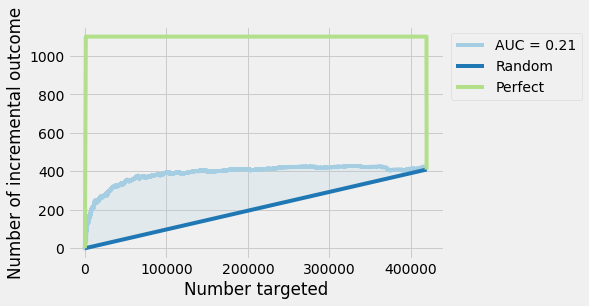

In [ ]:
plot_qini_curve(df_test[target_col], df_test['uplift_score_x'], df_test[treatment_col], perfect=True)

In [ ]:
# R-learner
r_learner = BaseRClassifier(outcome_learner=LogisticRegression(),
                            effect_learner=LinearRegression())

r_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = r_learner.predict(np.array(df_test[feature_cols].values.copy()))

df_test['uplift_score_r'] = uplift_vals

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

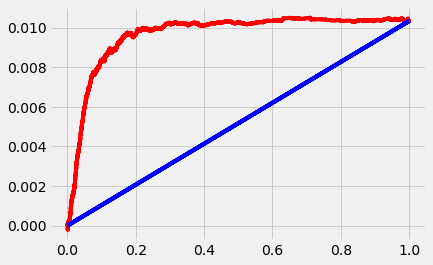

1880.5980300000003

In [ ]:
score_r = qini_df(df_test, 'uplift_score_r')
score_r

1880.5980300000003

In [ ]:
qini_r = qini_auc_score(df_test[target_col], df_test['uplift_score_r'], df_test[treatment_col], negative_effect=True)
qini_r

0.20484008603211193

0.20484008603211193

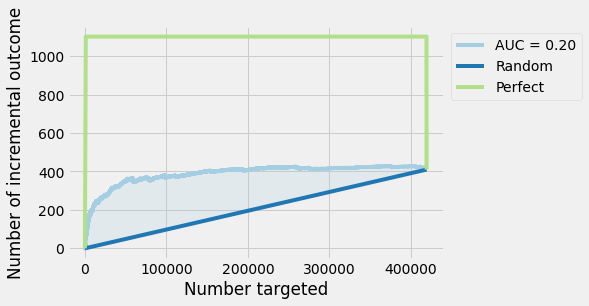

In [ ]:
plot_qini_curve(df_test[target_col], df_test['uplift_score_r'], df_test[treatment_col], perfect=True)

In [ ]:
# RandomForest
uplift_model = UpliftRandomForestClassifier(max_depth=5, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='ED', control_name='0')

uplift_model.fit(df_train[feature_cols].values,
                 treatment=df_train[treatment_col].apply(str).values,
                 y=df_train[target_col].values)

uplift_vals = uplift_model.predict(np.array(df_test[feature_cols].values.copy()))

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
df_test['uplift_score_rf'] = uplift_vals

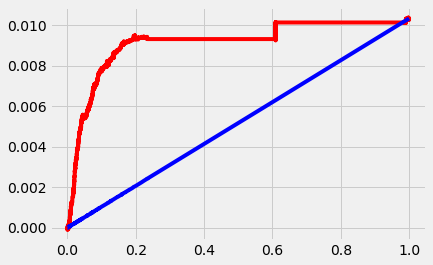

1628.1382600000002

In [ ]:
score_rf = qini_df(df_test, 'uplift_score_rf')
score_rf

1628.1382600000002

In [ ]:
qini_rf = qini_auc_score(df_test[target_col], df_test['uplift_score_rf'], df_test[treatment_col], negative_effect=True)
qini_rf

0.18630643652755424

0.18630643652755424

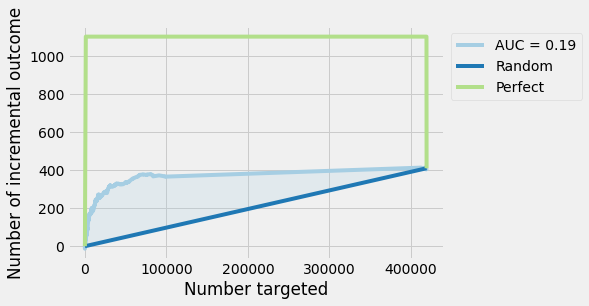

In [ ]:
plot_qini_curve(df_test[target_col], df_test['uplift_score_rf'], df_test[treatment_col], perfect=True)

In [ ]:
pd.DataFrame({"uplift-score":np.array([score_s, score_t, score_x, score_r, score_rf]),
              "qini-score": np.array([qini_s, qini_t, qini_x, qini_r, qini_rf])}, index=['S-learner', 'T-learner', 'X-learner', 'R-learner', 'UpliftRandomForest'])

,uplift-score,qini-score
S-learner,1701.94332,0.167573
T-learner,1149.30007,0.180406
X-learner,1752.82385,0.207476
R-learner,1880.59803,0.204840
UpliftRandomForest,1628.13826,0.186306


На таком размере датасета, лучше всего себя показали X-leaner и R-leaner, неожиданно слабо показал себя UpliftRandomForest. Худший результат у S-leaner. 